In [1]:
from sklearn.datasets import fetch_openml
import numpy as np

# Load images in RAM (MNIST)
X_flat, y = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto', return_X_y=True)
y = y.astype(int)
images = X_flat.reshape(-1, 28, 28).astype(np.uint8)

In [2]:
N_SAMPLES = 200  # number of MNIST images to use

# Limit dataset
images_sample, y_sample = images[:N_SAMPLES], y[:N_SAMPLES]

## Baseline: pixels

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from joblib import Parallel, delayed
import numpy as np

def cross_validation_parallel(feature_extractor, images, y):
    # Parallel feature extraction across all CPU cores
    X = Parallel(n_jobs=16, prefer="threads")(delayed(feature_extractor)(im) for im in images)
    X = np.vstack(X)
    print("Shape of the feature matrix:", X.shape)

    # classifier + CV
    clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_validate(clf, X, y, cv=cv, scoring=["accuracy", "f1_weighted"], n_jobs=-1, return_estimator=False)

    acc_folds = scores["test_accuracy"]        # shape (5,)
    f1w_folds = scores["test_f1_weighted"]     # shape (5,)

    print("Done with feature computation, starting classifier")
    print(f"Accuracy:  {acc_folds.mean():.4f} ± {acc_folds.std():.4f}  | folds: {acc_folds}")
    print(f"F1-weight: {f1w_folds.mean():.4f} ± {f1w_folds.std():.4f} | folds: {f1w_folds}")
    return X
def get_raw_pixels(img):
    return np.asarray(img, dtype=np.float32).ravel()

cross_validation_parallel(get_raw_pixels, images_sample, y_sample)

Shape of the feature matrix: (200, 784)
Done with feature computation, starting classifier
Accuracy:  0.8050 ± 0.0485  | folds: [0.825 0.725 0.8   0.875 0.8  ]
F1-weight: 0.7966 ± 0.0492 | folds: [0.81583333 0.71693362 0.80515873 0.8672619  0.77805195]


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(200, 784), dtype=float32)

## Baseline: persistent homology (persistence image)

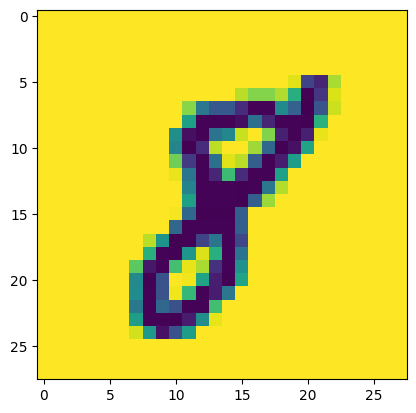

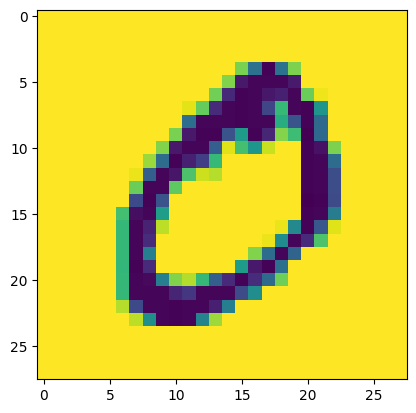

In [4]:
import matplotlib.pyplot as plt
img_8 = images_sample[17].astype(float)
img_8 = 255.0 - img_8  # superlevel via negation
plt.imshow(img_8)
plt.figure()
img_0 = images_sample[1].astype(float)
img_0 = 255.0 - img_0  # superlevel via negation
plt.imshow(img_0)

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

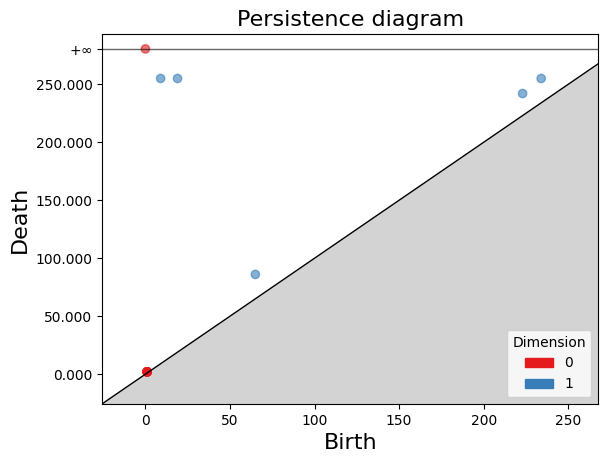

<Figure size 640x480 with 0 Axes>

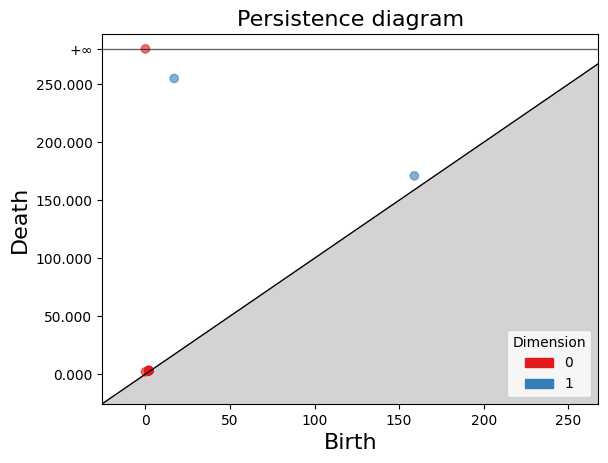

In [11]:
import gudhi as gd

complex_8 = gd.CubicalComplex(top_dimensional_cells=img_8)
dgmX = complex_8.persistence()
gd.plot_persistence_diagram(dgmX)
plt.figure()
complex_0 = gd.CubicalComplex(top_dimensional_cells=img_0)
dgmX = complex_0.persistence()
gd.plot_persistence_diagram(dgmX)

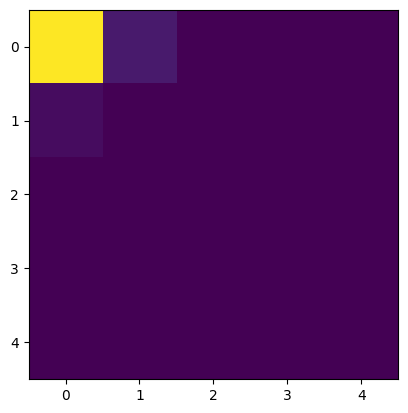

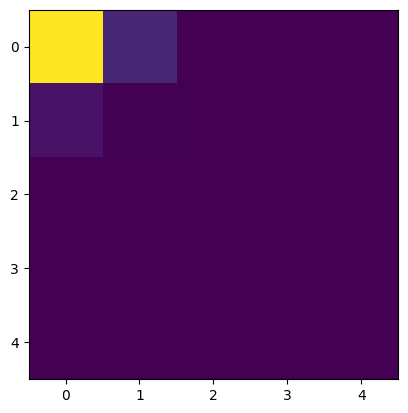

In [29]:
# testing persistence image from Gudhi
import gudhi.representations
import matplotlib.pyplot as plt

# 8
persistence_image_constructor = gd.representations.PersistenceImage(bandwidth=20, resolution=[5, 5], im_range=[0, 250, 0, 250], weight=lambda x: x[1]**2)
persistence_image = persistence_image_constructor.fit_transform([complex_8.persistence_intervals_in_dimension(1)])
plt.imshow(np.flip(np.reshape(persistence_image, [5,5]), 0))

plt.figure()

# 0
persistence_image_constructor = gd.representations.PersistenceImage(bandwidth=20, resolution=[5, 5], im_range=[0, 250, 0, 250], weight=lambda x: x[1]**2)
persistence_image = persistence_image_constructor.fit_transform([complex_0.persistence_intervals_in_dimension(1)])
plt.imshow(np.flip(np.reshape(persistence_image, [5,5]), 0))

In [30]:
import gudhi as gd
import gudhi.representations
def persistence_image_dim_1(image):
    image = 255.0 - image
    complex = gd.CubicalComplex(top_dimensional_cells=image)
    complex.compute_persistence()
    PI =  gd.representations.PersistenceImage(bandwidth=20, resolution=[50,50], im_range=[0, 250, 0, 250], weight=lambda x: x[1]**2)
    pi = PI.fit_transform([complex.persistence_intervals_in_dimension(1)])
    return pi.flatten()

X_dim1 = cross_validation_parallel(persistence_image_dim_1, images_sample, y_sample)

Shape of the feature matrix: (2000, 2500)
Done with feature computation, starting classifier
Accuracy:  0.2910 ± 0.0115  | folds: [0.295  0.275  0.2875 0.2875 0.31  ]
F1-weight: 0.2408 ± 0.0091 | folds: [0.24056716 0.22458382 0.24905061 0.2399794  0.24984734]


This is actually exactly as expected if only using 1st homology: groups {0, 6, 9}, {8}, {1,2,3,4,5,7} are classified, 
so classification accuracy is $$\frac{3}{10} \cdot \frac{1}{3} + \frac{1}{10} \cdot 1 + \frac{6}{10} \cdot \frac{1}{6} = 0.3, $$ assuming uniform distribution of numbers in the test data.


For the grouping {0}, {8}, {1,2}, the classification accuracy should be 
$$ \frac{1}{4} \cdot 1 + \frac{1}{4} \cdot 1 + \frac{1}{2} \cdot \frac{1}{2} = 0.75. $$ 

In [31]:
classes = {0, 8, 1, 2}
mask = np.isin(y, list(classes))

images_filtered = images[mask][:2000]
y_filtered = y[mask][:2000]
X_dim1_grouped = cross_validation_parallel(persistence_image_dim_1, images_filtered, y_filtered)

Shape of the feature matrix: (2000, 2500)
Done with feature computation, starting classifier
Accuracy:  0.7025 ± 0.0113  | folds: [0.6925 0.6925 0.715  0.7175 0.695 ]
F1-weight: 0.6804 ± 0.0117 | folds: [0.67101841 0.66797694 0.69731626 0.69138044 0.67408504]


Close enough, I believe my hypothesis. From looking at the persistence images of 0 and 8, they might be a bit hard to distinguish.

The next thing to do is add dimension 0 homology to the persistence image. All digits are connected, but perhaps we'll glean some information by how 'persistently' they are connected.

In [10]:
def replace_inf(arr, max_val):
    return np.where(np.isinf(arr), max_val, arr)

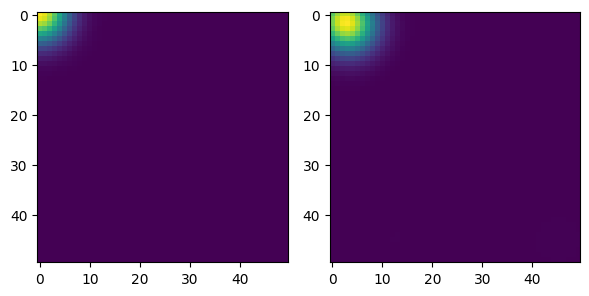

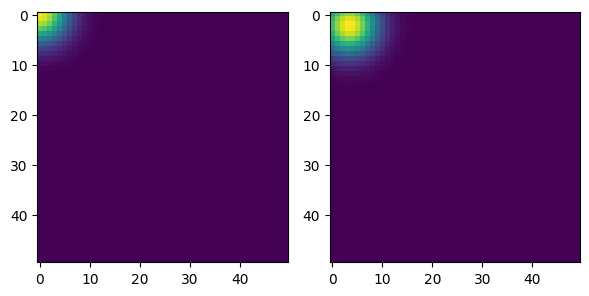

In [15]:
# 8
persistence_dim_0 = replace_inf(complex_8.persistence_intervals_in_dimension(0), 250)
persistence_dim_0
persistence_image_constructor = gd.representations.PersistenceImage(bandwidth=20, resolution=[50, 50], im_range=[0, 250, 0, 250], weight=lambda x: x[1]**2)
persistence_image = persistence_image_constructor.fit_transform([persistence_dim_0, complex_8.persistence_intervals_in_dimension(1)])
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
for i, ax in enumerate(axes):
    ax.imshow(np.flip(np.reshape(persistence_image[i], [50, 50]), 0), cmap="viridis")
plt.tight_layout()
plt.show()

# 0
persistence_dim_0 = replace_inf(complex_0.persistence_intervals_in_dimension(0), 250)
persistence_dim_0
persistence_image_constructor = gd.representations.PersistenceImage(bandwidth=20, resolution=[50, 50], im_range=[0, 250, 0, 250], weight=lambda x: x[1]**2)
persistence_image = persistence_image_constructor.fit_transform([persistence_dim_0, complex_0.persistence_intervals_in_dimension(1)])
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
for i, ax in enumerate(axes):
    ax.imshow(np.flip(np.reshape(persistence_image[i], [50, 50]), 0), cmap="viridis")
plt.tight_layout()
plt.show()

In [32]:
def persistence_image_dim_0(image):
    image = 255.0 - image
    complex = gd.CubicalComplex(top_dimensional_cells=image)
    complex.compute_persistence()
    PI =  gd.representations.PersistenceImage(bandwidth=20, resolution=[5, 5], im_range=[0, 250, 0, 250], weight=lambda x: x[1]**2)
    pi = PI.fit_transform([replace_inf(complex.persistence_intervals_in_dimension(0), 250)])
    return pi.flatten()

X_dim0 = cross_validation_parallel(persistence_image_dim_0, images_sample, y_sample)

Shape of the feature matrix: (2000, 25)
Done with feature computation, starting classifier
Accuracy:  0.1700 ± 0.0178  | folds: [0.2    0.17   0.1475 0.1575 0.175 ]
F1-weight: 0.1582 ± 0.0201 | folds: [0.19105335 0.15446621 0.13006642 0.14948628 0.16567864]


Training on just dimension 0 has above 10% accuracy, so maybe it will add some accuracy to the dimension 1 classifier.

In [33]:
def persistence_image_dim_0_dim_1(image):
    image = 255.0 - image
    complex = gd.CubicalComplex(top_dimensional_cells=image)
    complex.compute_persistence()
    PI =  gd.representations.PersistenceImage(bandwidth=20, resolution=[5,5], im_range=[0, 250, 0, 250], weight=lambda x: x[1]**2)
    pi = PI.fit_transform([replace_inf(complex.persistence_intervals_in_dimension(0), 250), complex.persistence_intervals_in_dimension(1)])
    return pi.reshape(1, -1)

X_dim0_dim1 = cross_validation_parallel(persistence_image_dim_0_dim_1, images_sample, y_sample)

Shape of the feature matrix: (2000, 50)
Done with feature computation, starting classifier
Accuracy:  0.3360 ± 0.0101  | folds: [0.3425 0.335  0.32   0.35   0.3325]
F1-weight: 0.3281 ± 0.0127 | folds: [0.33029035 0.32798653 0.30869908 0.34842673 0.32493617]


So, slightly better (notice we're feeding the model a vector twice the size now). Now let's see if adding the first nonzero eigenvalues will improve the model.

## Using smallest nonzero eigenvalues

In [34]:
import persistent_laplacians.persistent_laplacians as pl
from persistent_laplacians.cubical_complexes import get_filtration_data
import numpy as np

def get_nonpersistent_eigenvalues_from_image(image):
    image = 255.0 - image
    boundary_matrices, boundary_maps_index_dict, subsampled_filtration_indices = get_filtration_data(image, num_indices=5)
    result = pl.smallest_eigenvalue(
        boundary_matrices,
        boundary_maps_index_dict,
        filtration_subsampling=subsampled_filtration_indices,
        zero_tol=1e-6,
        use_scipy=True,
        use_stepwise_schur=False,
    )
    # Filter result to nonpersistent dim 1 features
    nonpersistent_dim1 = [
        (k[0], v)
        for k, v in result[1].items()
        if k[0] == k[1]
    ]
    nonpersistent_dim1.sort(key=lambda x: x[0])
    # Return first element of each or zero if missing
    nonzero_eigs = np.array([vec[0] if vec else 0 for _, vec in nonpersistent_dim1])
    return nonzero_eigs

/tmp/ipykernel_1114540/1919145444.py:8: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  result = pl.smallest_eigenvalue(


Error in scipy routine, falling back to dense computation: PyErr { type: <class 'TypeError'>, value: TypeError('Cannot use scipy.linalg.eigh for sparse A with k >= N. Use scipy.linalg.eigh(A.toarray()) or reduce k.'), traceback: Some(<traceback object at 0x7f8d6139af40>) }
Error in scipy routine, falling back to dense computation: PyErr { type: <class 'TypeError'>, value: TypeError('Cannot use scipy.linalg.eigh for sparse A with k >= N. Use scipy.linalg.eigh(A.toarray()) or reduce k.'), traceback: Some(<traceback object at 0x7f8d6141a800>) }


<Figure size 640x480 with 0 Axes>

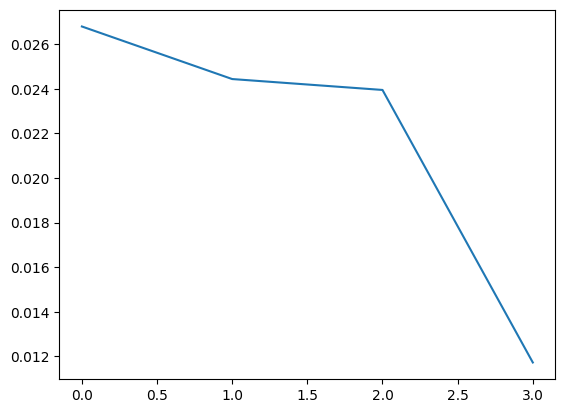

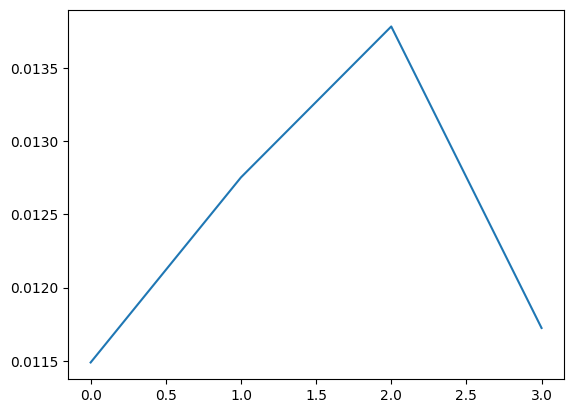

<Figure size 640x480 with 0 Axes>

In [20]:
# 5
nonpersistent_dim1_eigenvalues = get_nonpersistent_eigenvalues_from_image(images[0])
# first eigenvalue is quite large, skipping to see the others better
plt.plot(nonpersistent_dim1_eigenvalues[1:])
plt.figure()

# 0
nonpersistent_dim1_eigenvalues = get_nonpersistent_eigenvalues_from_image(images[1])
plt.plot(nonpersistent_dim1_eigenvalues[1:])
plt.figure()


In [35]:
X_eig_dim1 = cross_validation_parallel(get_nonpersistent_eigenvalues_from_image, images_sample, y_sample)

KeyboardInterrupt: 

Now we will simply append this data to the computation of the persistence image in dimension 1 (I am not including dimension 0 because I suspect that the more data we give the classifier, the harder it will be for it to meaningfully use the persistence data).

In [38]:
def concatenate(features):
    return lambda image: np.concatenate([f(image) for f in features])


In [44]:
dim1_pi_dim_1_nonpersistent_eigen = concatenate([persistence_image_dim_1, get_nonpersistent_eigenvalues_from_image])
X_dim1_pi_dim_1_nonpersistent_eigen = cross_validation_parallel(dim1_pi_dim_1_nonpersistent_eigen, images_sample, y_sample)

/tmp/ipykernel_1114540/1919145444.py:8: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  result = pl.smallest_eigenvalue(


Error in scipy routine, falling back to dense computation: PyErr { type: <class 'TypeError'>, value: TypeError('Cannot use scipy.linalg.eigh for sparse A with k >= N. Use scipy.linalg.eigh(A.toarray()) or reduce k.'), traceback: Some(<traceback object at 0x7f8d403aa800>) }
Error in scipy routine, falling back to dense computation: PyErr { type: <class 'TypeError'>, value: TypeError('Cannot use scipy.linalg.eigh for sparse A with k >= N. Use scipy.linalg.eigh(A.toarray()) or reduce k.'), traceback: Some(<traceback object at 0x7f8d7f5e8c40>) }
Error in scipy routine, falling back to dense computation: PyErr { type: <class 'TypeError'>, value: TypeError('Cannot use scipy.linalg.eigh for sparse A with k >= N. Use scipy.linalg.eigh(A.toarray()) or reduce k.'), traceback: Some(<traceback object at 0x7f8d1c302f40>) }
Error in scipy routine, falling back to dense computation: PyErr { type: <class 'TypeError'>, value: TypeError('Cannot use scipy.linalg.eigh for sparse A with k >= N. Use scipy.l

In [52]:
dim0_pi_dim1_pi_dim_1_nonpersistent_eigen = concatenate([persistence_image_dim_0, persistence_image_dim_1, get_nonpersistent_eigenvalues_from_image])
cross_validation_parallel(dim0_pi_dim1_pi_dim_1_nonpersistent_eigen, images_sample, y_sample)

/tmp/ipykernel_1114540/1919145444.py:8: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  result = pl.smallest_eigenvalue(


Error in scipy routine, falling back to dense computation: PyErr { type: <class 'TypeError'>, value: TypeError('Cannot use scipy.linalg.eigh for sparse A with k >= N. Use scipy.linalg.eigh(A.toarray()) or reduce k.'), traceback: Some(<traceback object at 0x7f8d1c2f5280>) }
Error in scipy routine, falling back to dense computation: PyErr { type: <class 'TypeError'>, value: TypeError('Cannot use scipy.linalg.eigh for sparse A with k >= N. Use scipy.linalg.eigh(A.toarray()) or reduce k.'), traceback: Some(<traceback object at 0x7f8d1c278640>) }
Error in scipy routine, falling back to dense computation: PyErr { type: <class 'TypeError'>, value: TypeError('Cannot use scipy.linalg.eigh for sparse A with k >= N. Use scipy.linalg.eigh(A.toarray()) or reduce k.'), traceback: Some(<traceback object at 0x7f8d1c53ff80>) }
Error in scipy routine, falling back to dense computation: PyErr { type: <class 'TypeError'>, value: TypeError('Cannot use scipy.linalg.eigh for sparse A with k >= N. Use scipy.l

## Summary of classification results

For only dimension 0 persistence image:
- Accuracy:  0.2400 ± 0.0300  | folds: [0.3   0.225 0.225 0.225 0.225]
- F1-weight: 0.2117 ± 0.0326 | folds: [0.27025253 0.19843222 0.1825     0.184375   0.22291667]

For only dimension 1 persistence image:
- Accuracy:  0.3000 ± 0.0418  | folds: [0.325 0.25  0.25  0.325 0.35 ]
- F1-weight: 0.2407 ± 0.0389 | folds: [0.24883117 0.18375    0.21088023 0.26820818 0.29192719]

For dimension 0 + dimension 1 persistence image: 
- Accuracy:  0.3300 ± 0.0187  | folds: [0.35  0.35  0.3   0.325 0.325]
- F1-weight: 0.3081 ± 0.0282 | folds: [0.33841991 0.33497475 0.27108586 0.27857143 0.31763709]

For dimension 1 nonpersistent eigenvalues: 
- Accuracy:  0.2650 ± 0.0300  | folds: [0.25  0.3   0.25  0.3   0.225]
- F1-weight: 0.2483 ± 0.0356 | folds: [0.21529915 0.2839369  0.24162698 0.29450216 0.2060878 ]

For dimension 1 nonpersistent eigenvalues + dimension 1 persistence image:
- Accuracy:  0.3150 ± 0.0644  | folds: [0.375 0.325 0.2   0.3   0.375]
- F1-weight: 0.2959 ± 0.0557 | folds: [0.31463203 0.29998279 0.19938936 0.29349206 0.37218615]

For dimension 1 nonpersistent eigenvalues + dimension 0 persistence image + dimension 1 persistence image:
- Accuracy:  0.3700 ± 0.0367  | folds: [0.35  0.325 0.35  0.4   0.425]
- F1-weight: 0.3375 ± 0.0453 | folds: [0.29884199 0.29       0.3189899  0.37156593 0.40828283]


## There are lots more things to look into...
- How changing the parameters per feature (num indices, size of image) affects classification accuracy,
- How other dimensions of the eigenvalues do in classification, ...
But it seems that the nonpersistent eigenvalues add some information to the dimension 0 + dimension 1 persistence image classifiers. 


Next, confusion matrix UMAP visualisation of the features to see if there is clear clustering. 

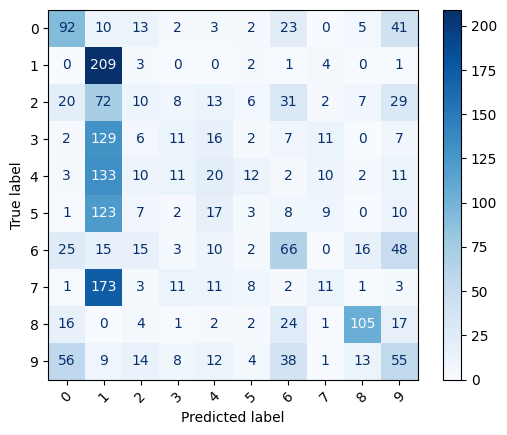

In [12]:
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

def plot_confusion_matrix(X, y_sample):
    # Get out-of-fold predictions
    y_pred = cross_val_predict(clf, X, y_sample, cv=cv, n_jobs=-1)

    # Confusion matrix
    cm = confusion_matrix(y_sample, y_pred)

    # Nicely plotted
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_sample))
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.show()

    return X

X = plot_confusion_matrix(X_dim1, y_sample)

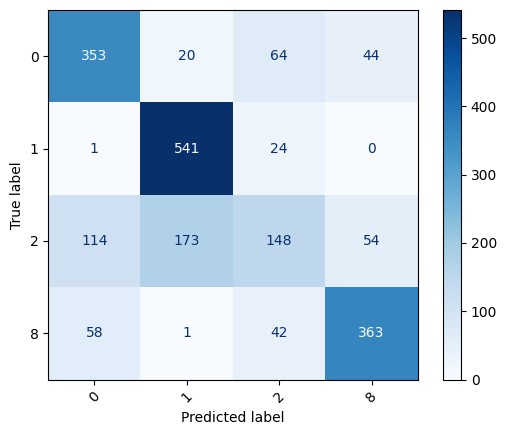

array([[9.03027819e-16, 6.64271510e-15, 4.57854533e-14, ...,
        2.12736814e-26, 1.20099154e-27, 6.35293833e-29],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.85987128e-20, 2.82097218e-19, 2.60728506e-18, ...,
        4.21271478e-23, 1.95100503e-23, 8.46650664e-24],
       ...,
       [4.52257049e-34, 4.49089586e-34, 4.17847702e-34, ...,
        5.05367986e-30, 2.35620442e-31, 1.02933230e-32],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.15514053e-27, 2.16751795e-27, 2.04261825e-27, ...,
        3.84386172e-30, 1.81514977e-31, 8.03146129e-33]],
      shape=(2000, 2500))

In [15]:
plot_confusion_matrix(persistence_image_dim_1, images_filtered, y_filtered)

/home/marmas/personal/repos/persistent-laplacians/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


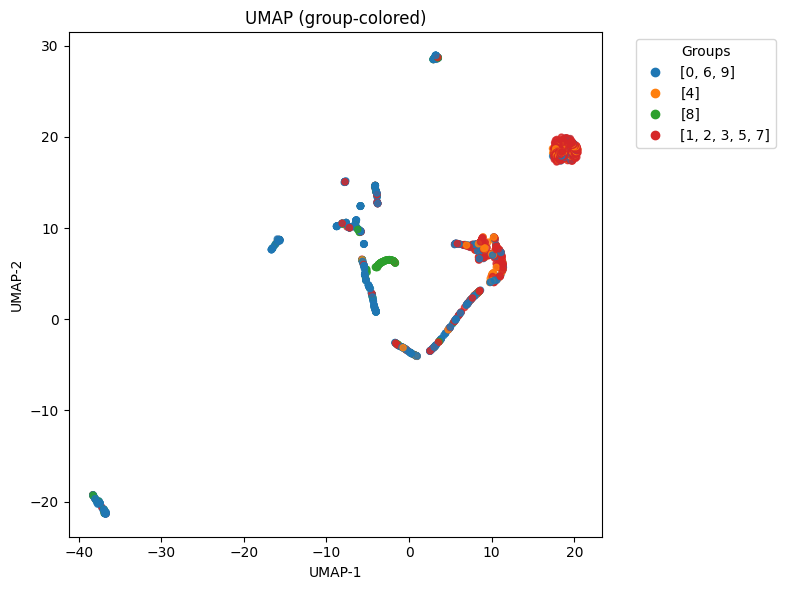

In [28]:
import numpy as np
import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap, BoundaryNorm

def umap_grouped_plot(
    X, labels, groups, group_names=None, scale=False,
    n_neighbors=15, min_dist=0.1, metric="euclidean", random_state=42,
    show_unknown=True
):
    # optional scaling
    if scale:
        X = StandardScaler().fit_transform(X)

    # UMAP (2D)
    Z = umap.UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=42, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=False).fit_transform(X)

    # map label -> group id
    label2group = {int(lbl): gid for gid, grp in enumerate(groups) for lbl in grp}
    g_ids = np.array([label2group.get(int(y), -1) for y in labels], dtype=int)

    # discrete colors: gid k -> color k (fixed)
    n_groups = len(groups)
    base = plt.get_cmap("tab10")
    colors = [base(i % base.N) for i in range(n_groups)]
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(np.arange(-0.5, n_groups + 0.5, 1), cmap.N)

    plt.figure(figsize=(8, 6))
    known = g_ids != -1
    plt.scatter(Z[known, 0], Z[known, 1], c=g_ids[known],
                cmap=cmap, norm=norm, s=20, alpha=0.8)

    # unknowns (labels not in any group)
    if show_unknown and (~known).any():
        plt.scatter(Z[~known, 0], Z[~known, 1], c="lightgray", s=15, alpha=0.6, label="Other")

    # legend with exact group colors
    handles, texts = [], []
    for gid in range(n_groups):
        h = plt.Line2D([0], [0], marker='o', linestyle='', markersize=6, color=colors[gid])
        handles.append(h)
        name = group_names[gid] if group_names else str(groups[gid])
        texts.append(name)
    if show_unknown and (~known).any():
        handles.append(plt.Line2D([0], [0], marker='o', linestyle='', markersize=6, color='lightgray'))
        texts.append("Other")

    plt.legend(handles, texts, title="Groups", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.title("UMAP (group-colored)")
    plt.xlabel("UMAP-1"); plt.ylabel("UMAP-2")
    plt.tight_layout(); plt.show()
    return Z

# Z = umap_grouped_plot([get_raw_pixels(x) for x in images_sample], y_sample, [[x] for x in range(0, 10)])
Z = umap_grouped_plot(X, y_sample, [[0, 6, 9], [4], [8], [1,2,3,5,7]])
